In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
from tqdm.auto import tqdm
import itertools, os
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(5,5)})

#### Set choices

USPS is among: 
```
print(sorted(census_tracts['USPS'].unique()))
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
```
    

In [2]:
#filterUSPS = ['MD']
filterUSPS = ['MD', 'DC', 'VA', 'DE', 'PA', 'NJ']
#filterUSPS = ['CA', 'OR', 'WA']
foldername = '../../data/around-maryland/'
#foldername = '../../data/west-coast/'
#foldername = '../../data/maryland/'

In [3]:
commute_data = pd.read_csv('united-states-commutes/commute_data.csv', dtype={'OFIPS': str, 'DFIPS': str})
census_tracts = pd.read_csv('united-states-commutes/census_tracts_2010.csv', dtype={'GEOID': str})
census_tracts = census_tracts[census_tracts['USPS'].isin(filterUSPS)]
commute_data = commute_data[commute_data['OFIPS'].isin(census_tracts['GEOID'].unique())]
commute_data = commute_data[commute_data['DFIPS'].isin(census_tracts['GEOID'].unique())]
census_tracts = census_tracts.sort_values('POP10', ascending=True)
census_tracts.reset_index(inplace=True)
commute_data.reset_index(inplace=True)

From readme:

    - Ofips - the full FIPS code for the origin census tract of an individual flow line
    - Dfips  - the full FIPS code for the destination census tract of an individual flow line
    - Ostfips - the FIPS code for the origin state of an individual flow line
    - Octfips - the FIPS code for the origin county of an individual flow line
    - Otrfips - the FIPS code for the origin census tract of an individual flow line
    - Dstfips - the FIPS code for the destination state of an individual flow line
    - Dctfips - the FIPS code for the destination county of an individual flow line
    - Dtrfips - the FIPS code for the destination census tract of an individual flow line
    - Flow - the total number of commuters associated with this individual point to point flow line (i.e. the total number of journeys to work)
    - Moe - margin of error of the Flow value above
    - LenKM - length of each flow line, in Kilometers
    - ESTDIVMOE - the Flow value divided by the Margin of Error of the estimate 

In [4]:
commute_data.head()

,index,OFIPS,DFIPS,OSTFIPS,OCTFIPS,OTRFIPS,DSTFIPS,DCTFIPS,DTRFIPS,FLOW,MOE,LENKM,ESTDIVMOE
0,1,51710000902,51710000902,51,710,902,51,710,902,10155,2516,0.0,4.04
1,11,51700032300,51700032300,51,700,32300,51,700,32300,4950,1872,0.0,2.64
2,19,51153901100,51153901100,51,153,901100,51,153,901100,3670,1491,0.0,2.46
3,26,51149850200,51149850200,51,149,850200,51,149,850200,2915,1025,0.0,2.84
4,32,51810040000,51810040000,51,810,40000,51,810,40000,2555,1546,0.0,1.65


from https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/gaz10-record-layouts.html

    USPS	United States Postal Service State Abbreviation
    GEOID	Geographic Identifier - fully concatenated geographic code (State FIPS and district number)
    POP10	2010 Census population count.
    HU10	2010 Census housing unit count.
    ALAND	Land Area(square meters) - Created for statistical purposes only.
    AWATER	Water Area (square meters) - Created for statistical purposes only.
    ALAND_SQMI	Land Area (square miles) - Created for statistical purposes only.
    AWATER_SQMI	Water Area (square miles) - Created for statistical purposes only.
    INTPTLAT	Latitude (decimal degrees) First character is blank or "-" denoting North or South latitude respectively.
    INTPTLONG	Longitude (decimal degrees) First character is blank or "-" denoting East or West longitude respectively.

In [5]:
attribution = np.empty(len(census_tracts))
attribution[:] = np.nan
for index, row in tqdm(census_tracts.iterrows(), total=census_tracts.shape[0]):
            attribution[index] = int(str(row['GEOID'])[:5])
census_tracts['county'] = attribution
counties_names = np.unique(attribution)
n_counties = len(counties_names)

pop = np.zeros(n_counties)
state_USPS = []
for i, ct in enumerate(counties_names):
    pop[i] = census_tracts[census_tracts['county'] == ct]['POP10'].sum()
    state_USPS.append(census_tracts[census_tracts['county'] == ct].USPS.iloc[0])
    
groups = {'geoid' : counties_names,
          'pop2010' : pop,
          'stateUSPS':state_USPS }
geodata = pd.DataFrame.from_dict(groups)

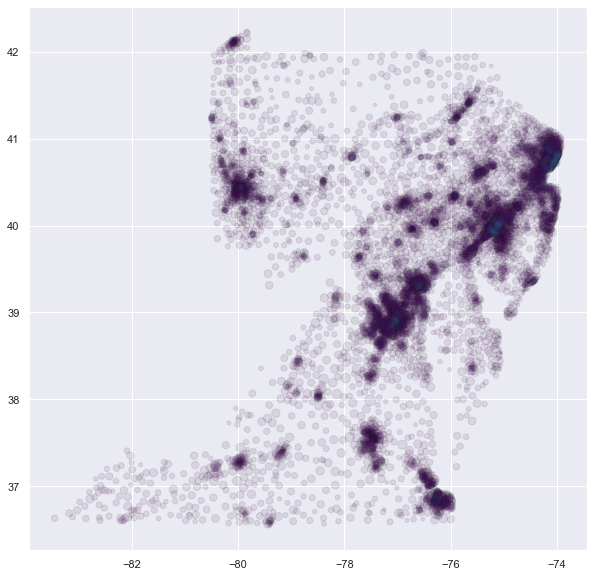

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(census_tracts['INTPTLONG'], census_tracts['INTPTLAT'], s =census_tracts['POP10']/100,
           edgecolors = 'k', c =census_tracts['POP10']/census_tracts['ALAND']*1e5, 
           cmap='viridis', alpha = .1)

In [7]:
mobility = np.zeros((n_counties, n_counties))

ori_col =  commute_data['OFIPS'].apply(lambda str: float(str[:5]))
dest_col = commute_data['DFIPS'].apply(lambda str: float(str[:5]))

for ori_i, ori_v in tqdm(enumerate(counties_names), total = len(counties_names)):
    for dest_i, dest_v in enumerate(counties_names):
        
        mobility[ori_i][dest_i] = commute_data[(ori_col  == ori_v) & (dest_col == dest_v)]['FLOW'].sum()
    

### A little postprocessing... 

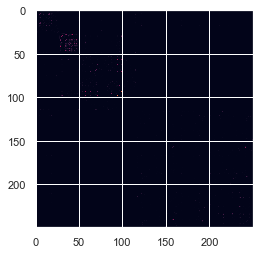

In [8]:
np.fill_diagonal(mobility,0)
mobility = mobility + mobility.T # Symetric mobility doubling fluxes mobility.sum is around 5M which is a bit low
plt.imshow(mobility)

### Saving setup ...

In [9]:
if not os.path.exists(foldername):
    os.makedirs(foldername)
np.savetxt(f'{foldername}mobility.txt', mobility)
geodata.to_csv(f'{foldername}geodata.csv', index_label='id')